# Predicting Hotel Reservation Cancellations

## Introduction

This project intorduces the possibility if anyone want to know the chances wishes to find out different aspects when booking a hotel. Some of these aspects may include the following.
- Finding out when Hotel stays are likely to be canceled.
- Projected revenue due to cancellations and other factors
- If Hotels are likely to be canceled, will they provide a more afordable pricing for the consumer.
- Season, month day of the year to take advantage of possible lower costs due to cancellation.
- Causes of cancellation weather it be be cause of the season or a variety of different factors

### The Dataset 

The Dataset is an open dataset provided by Kaggle.

The dataset can be found as this url: https://www.kaggle.com/jessemostipak/hotel-booking-demand
The original source of this dataset before being published in Kaggle can be found at this url: https://www.sciencedirect.com/science/article/pii/S2352340918315191

The dataset contains booking information on the hotel, the type of hotel and a variety of services and amenities provided. Since this is a public dataset, no personal information in identifiable by observations in the dataset.

In [1]:
#First we import the neccessary libraries to perform our analysis / experiment
import pandas as pd
import numpy as np
import pydotplus
import graphviz

import seaborn as sns
from matplotlib import pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px

import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

import xgboost as xgb
from xgboost import XGBClassifier

from scipy.stats.mstats import winsorize
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.tree import export_graphviz
from sklearn import tree, preprocessing, ensemble
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler

from statsmodels.tools.eval_measures import mse, rmse
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
#Loading teh Dataset
hotel_df = pd.read_csv('hotel_bookings.csv')

In [3]:
#Viewing the initial information and head of the Dataset
hotel_df.info()
hotel_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1                        0                     0       2  ...    No Deposit   
2                        0                     1       1  ...    No Deposit   
3                        0                     1       1  ...    No Deposit   
4                        0                     2       2  ...    No Deposit   

   agent company days_in_waiting_list customer_type   adr  \
0    NaN     NaN                    0     Transient   0.0   
1    NaN     NaN                    0     Transient   0.0   
2    NaN     NaN                    0     Transient  75.0   
3  304.0     NaN                    0     Transient  75.0   
4  240.0     NaN                    0     Transient  98.0   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          0           Check-Out   
2                            0                          0           Check-Out   
3                            0                          0           Check-Out   
4                            0                          1           Check-Out   

  reservation_status_date  
0              2015-07-01  
1              2015-07-01  
2              2015-07-02  
3              2015-07-02  
4              2015-07-03  

[5 rows x 32 columns]

In [4]:
#We then view the columns sorted
hotel_df.columns.sort_values()

Index(['adr', 'adults', 'agent', 'arrival_date_day_of_month',
       'arrival_date_month', 'arrival_date_week_number', 'arrival_date_year',
       'assigned_room_type', 'babies', 'booking_changes', 'children',
       'company', 'country', 'customer_type', 'days_in_waiting_list',
       'deposit_type', 'distribution_channel', 'hotel', 'is_canceled',
       'is_repeated_guest', 'lead_time', 'market_segment', 'meal',
       'previous_bookings_not_canceled', 'previous_cancellations',
       'required_car_parking_spaces', 'reservation_status',
       'reservation_status_date', 'reserved_room_type', 'stays_in_week_nights',
       'stays_in_weekend_nights', 'total_of_special_requests'],
      dtype='object')

### Investigating Missing Values

In order to good results, and analyze the data further. We will first clean the dataset by Identifying any missing or null values.

In [5]:
#viewing the sum of all null values
hotel_df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

As we can see, there are 4 columns with missing values. the children feature only has 4 missing but the company feature is missing a substantial amount of data. We will then look at the percentage of null values to give us a clearer picture.

In [6]:
hotel_df.isnull().sum()*100 / hotel_df.isna().count()

hotel                              0.000000
is_canceled                        0.000000
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
children                           0.003350
babies                             0.000000
meal                               0.000000
country                            0.408744
market_segment                     0.000000
distribution_channel               0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                    

We will also plot a heatmap of missing values to view how much of the dataset has missing values

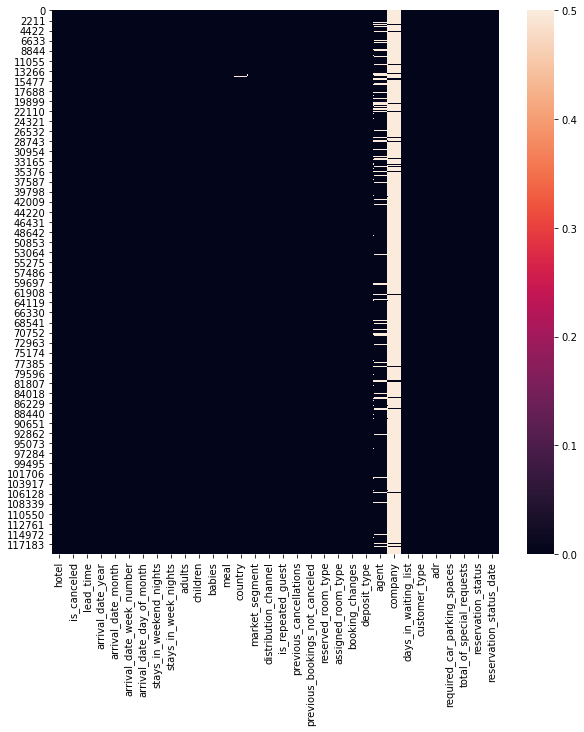

In [7]:
#Plotting a heatmap with null values
plt.figure(figsize=(10,10))
sns.heatmap(hotel_df.isnull(), vmin=0, vmax=0.5)
plt.show()

The feature 'company' has a substantial amount of null values with approximately 94%. We can safely drop the entire feature with this assumption.

The 'agent' column also has about 13% null values. Since this feature is a float, we will fill in the missing values with the 'median' of this feature.

The 'children' feature has about 0.33 null values which are approximately 3 observations. This is a very small amount and dropping these observations shall have no immidiate impact. Lastly. the 'country' feature also has null values below 5% and should be safe to drop this feature as well.


In [8]:
#Dropping the 'company' feature with over 94% of null values
hotel_df.drop(columns='company', inplace=True)

#filling null values of the feature 'agent'
hotel_df['agent'].fillna(hotel_df['agent'].median(), inplace=True)

#Dropping the null values of 'children'
hotel_df.dropna(subset=['country','children'], inplace=True )


Veryfying that the null columns has been taken care of by looking at its percentage

In [9]:
hotel_df.isnull().sum()*100 / hotel_df.isna().count()

hotel                             0.0
is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
market_segment                    0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
assigned_room_type                0.0
booking_changes                   0.0
deposit_type                      0.0
agent                             0.0
days_in_waiting_list              0.0
customer_type                     0.0
adr         

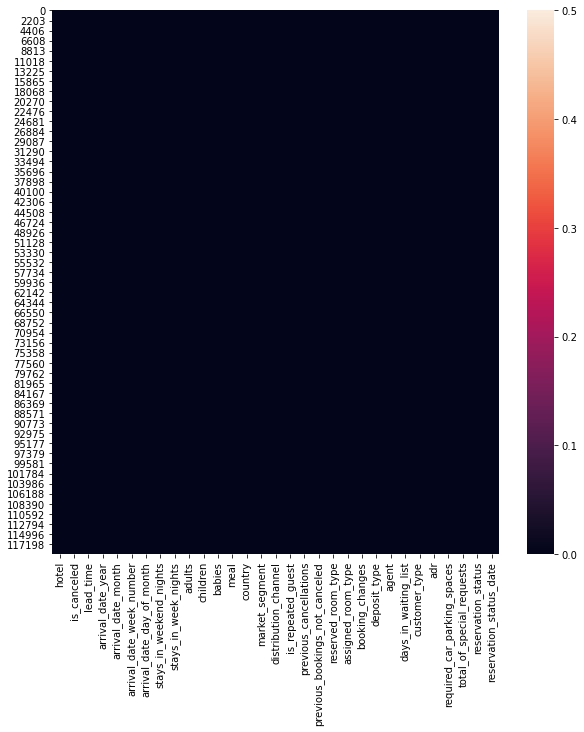

In [10]:
#Plotting heatmap again to verify that the missing values are now taken care of.
plt.figure(figsize=(10,10))
sns.heatmap(hotel_df.isna(),  vmin=0, vmax=0.5)
plt.show()

As we can see above, the missing values have been taken care of.

## Outlier Detection and transformation

We will select a few features and look at their outliers. Any significant outliers will be transformed accordingly.

Out first selection is the individual and family unit.

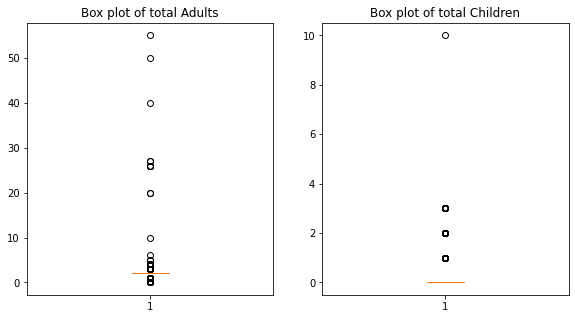

In [11]:
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
plt.boxplot(hotel_df['adults'], whis = 5)
plt.title("Box plot of total Adults")

plt.subplot(1,3,2)
plt.boxplot(hotel_df['children'], whis = 5)
plt.title("Box plot of total Children")

plt.show()

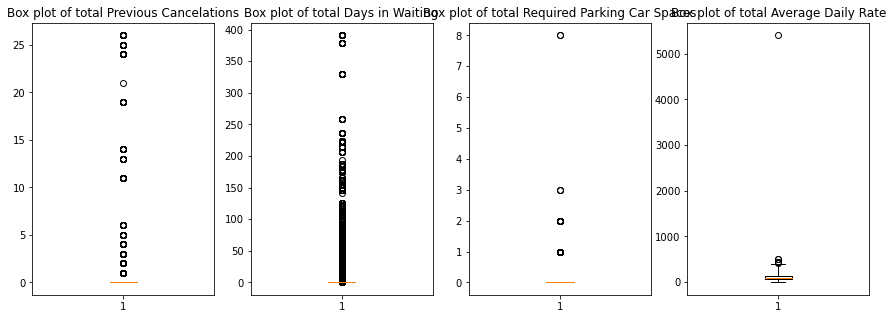

In [12]:
plt.figure(figsize = (15,5))

plt.subplot(1,4,1)
plt.boxplot(hotel_df['previous_cancellations'], whis = 5)
plt.title("Box plot of total Previous Cancelations")

plt.subplot(1,4,2)
plt.boxplot(hotel_df['days_in_waiting_list'], whis = 5)
plt.title("Box plot of total Days in Waiting")

plt.subplot(1,4,3)
plt.boxplot(hotel_df['required_car_parking_spaces'], whis = 5)
plt.title("Box plot of total Required Parking Car Spaces")

plt.subplot(1,4,4)
plt.boxplot(hotel_df['adr'], whis = 5)
plt.title("Box plot of total Average Daily Rate")

plt.show()

As seen above, there are some outliers. We can transform these outliers

Results after winsorization method in transforming outliers

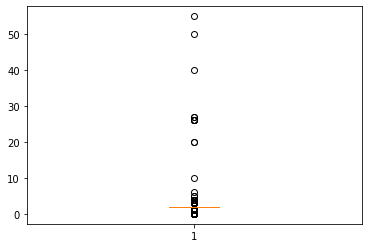

In [13]:
#Function to winsorize a specific feature
def winsor(df):
    plt.boxplot(winsorize(df))
    plt.show()

winsor(hotel_df['adults'])

## Data Exploration

Fist we will look at the data once more to get a statistical inference summary of each of the features. This will lead us in making decisions as we proceed further with our analysis

In [14]:
hotel_df.describe()

is_canceled      lead_time  arrival_date_year  \
count  118898.000000  118898.000000      118898.000000   
mean        0.371352     104.311435        2016.157656   
std         0.483168     106.903309           0.707459   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     161.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             118898.000000              118898.000000   
mean                  27.166555                  15.800880   
std                   13.589971                   8.780324   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%                   38.000000                  23.000000   
max                   53.000000                  31.000000   

       stays_in_weekend_nights  stays_in_week_nights         adults  \
count            118898.000000         118898.000000  118898.000000   
mean                  0.928897              2.502145       1.858391   
std                   0.996216              1.900168       0.578576   
min                   0.000000              0.000000       0.000000   
25%                   0.000000              1.000000       2.000000   
50%                   1.000000              2.000000       2.000000   
75%                   2.000000              3.000000       2.000000   
max                  16.000000             41.000000      55.000000   

            children         babies  is_repeated_guest  \
count  118898.000000  118898.000000      118898.000000   
mean        0.104207       0.007948           0.032011   
std         0.399172       0.097380           0.176029   
min         0.000000       0.000000           0.000000   
25%         0.000000       0.000000           0.000000   
50%         0.000000       0.000000           0.000000   
75%         0.000000       0.000000           0.000000   
max        10.000000      10.000000           1.000000   

       previous_cancellations  previous_bookings_not_canceled  \
count           118898.000000                   118898.000000   
mean                 0.087142                        0.131634   
std                  0.845869                        1.484672   
min                  0.000000                        0.000000   
25%                  0.000000                        0.000000   
50%                  0.000000                        0.000000   
75%                  0.000000                        0.000000   
max                 26.000000                       72.000000   

       booking_changes          agent  days_in_waiting_list            adr  \
count    118898.000000  118898.000000         118898.000000  118898.000000   
mean          0.221181      76.780703              2.330754     102.003243   
std           0.652785     105.928127             17.630452      50.485862   
min           0.000000       1.000000              0.000000      -6.380000   
25%           0.000000       9.000000              0.000000      70.000000   
50%           0.000000      14.000000              0.000000      95.000000   
75%           0.000000     152.000000              0.000000     126.000000   
max          21.000000     535.000000            391.000000    5400.000000   

       required_car_parking_spaces  total_of_special_requests  
count                118898.000000              118898.000000  
mean                      0.061885                   0.571683  
std                       0.244172                   0.792678  
min                       0.000000                   0.000000  
25%                       0.000000                   0.000000  
50%                       0.000000                   0.000000  
75%                       0

We will also get any numerical correlation there are amongst the features. This will help us decide later on on what features can be more useful than others. The heatmap below shows any positive and negatively correlated features we will be using at a later point.

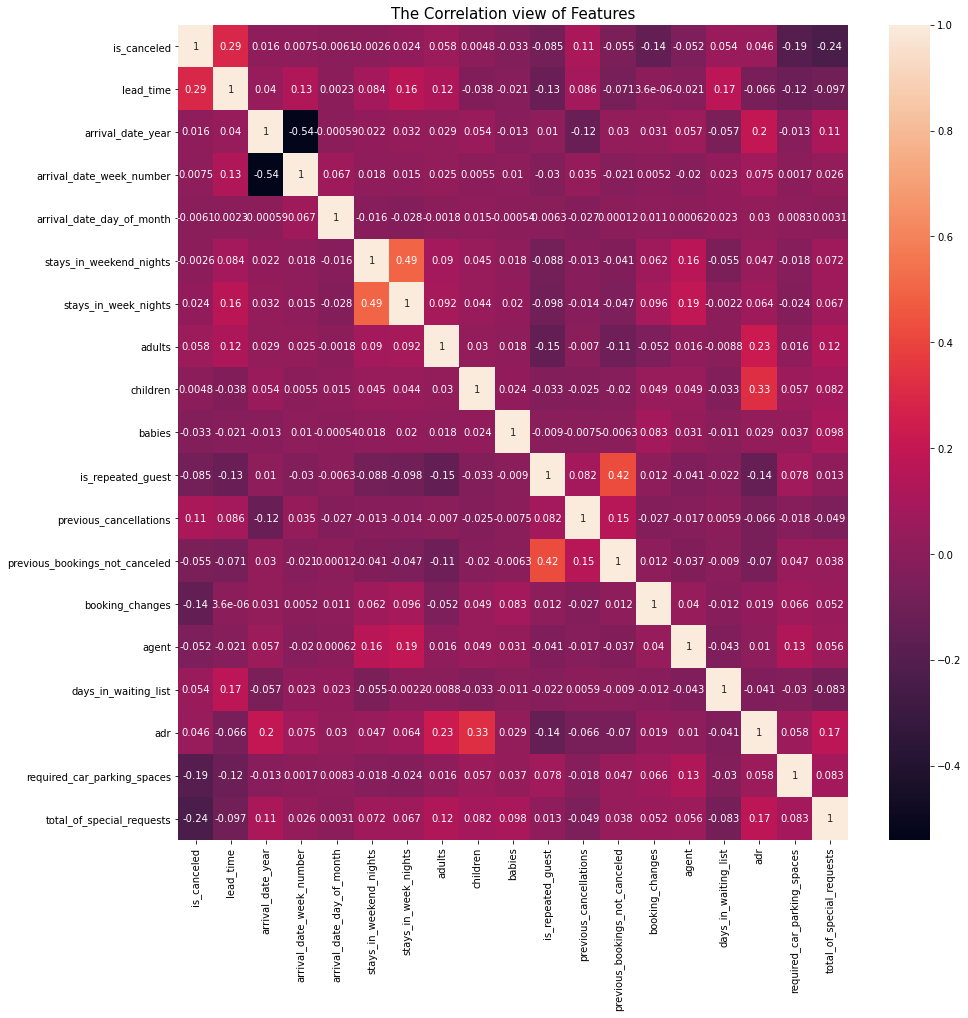

In [15]:
plt.figure(figsize=(15,15))
sns.heatmap(hotel_df.corr(), annot=True)
plt.title('The Correlation view of Features', fontsize=15)
plt.show()

__Insights from the correlation plot__

The following are some of the insights that may be derived from running the correlation plot above. Some insights may be a bit suprising and others may be evident.
- Repeat guests are less likely to cancel their reservations
- The lead time (advance reservation) is related to weather or not bookings will be canceled.
- Guests with families and children are more likely to look at the ADR ('Average Daily Rate') as a factor in making decisions.
- Guests staying during weekdays also tends to stay on weekends.
****
- In contrast, adults booking has not correlation with the ADR ('Average Daily Rate'). This may be due to factores such as personal or business travel where companies pay for their expenses.
****
- Special requests has little correlation or no effect on if a guest cancels a booking or not.
- Their arrival date does not have any correlation on the arrival year. This could signify that they do not neccessarily book to the same place every year.



Since we will be predicting the cancellation of the hotel, we will first analyze this feature by separating guests who cancelled and guests who have not.

In [16]:
#Getting the unique value
hotel_df['is_canceled'].unique()

array([0, 1], dtype=int64)

In [17]:
#Separating cancellations from not
canceled = hotel_df[hotel_df['is_canceled'] == 1]
not_canceled = hotel_df[hotel_df['is_canceled'] == 0]

print('The number of total bookings from the is_canceled feature is {}'.format(len(hotel_df['is_canceled'])))
print('The percentage of bookings who did NOT CANCEL were {0:.2f} %'.format((len(not_canceled) / len(hotel_df['is_canceled'])) * 100))
print('The percentage of bookings which CANCELED were {0:.2f} %'.format((len(canceled) / len(hotel_df['is_canceled'])) * 100))

The number of total bookings from the is_canceled feature is 118898
The percentage of bookings who did NOT CANCEL were 62.86 %
The percentage of bookings which CANCELED were 37.14 %


#### ** Moving forward we will refer to __Guests__ as bookings which were __Not Canceled__. Bookings or Reservations which proceeded as scheduled. **

#### What countries have the most guests?

Plotting the distributions of guests for the top 10 countries. 

Getting the top 10 countries with the most guests.

In [18]:
top_countries = not_canceled['country'].value_counts().head(10)
top_countries = pd.DataFrame(top_countries)

In [19]:
figure = px.pie(top_countries, names=['Portugal','Great Britan', 'France', 'Spain', 'Germany', 'Ireland',
                                     'Italy', 'Belgium', 'The Neatherlands', 'USA'], values=top_countries)

figure.update_layout(title={'text': 'Distribution of top 10 Countries with the most number of Guests'},
                    font=dict(size=14))
figure.show()

__Insights from the Pie plot__

The Top 10 countries represented in the Pie plot with the most guests are Portugal, Great Britain, France, Spain, Germany, Ireland, Italy, Belgium, The Neatherlands and USA

In [20]:
#Creating the list of months in order to put them in order of time.
months_in_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

#Arranging months in the dataframe to show as ordered everytime it is called.
not_canceled['arrival_date_month'] = pd.Categorical(not_canceled['arrival_date_month'], categories=months_in_order, ordered=True)
hotel_df['arrival_date_month'] = pd.Categorical(hotel_df['arrival_date_month'], categories=months_in_order, ordered=True)

#### Which month has the highest cost ('Average Daily Rate')

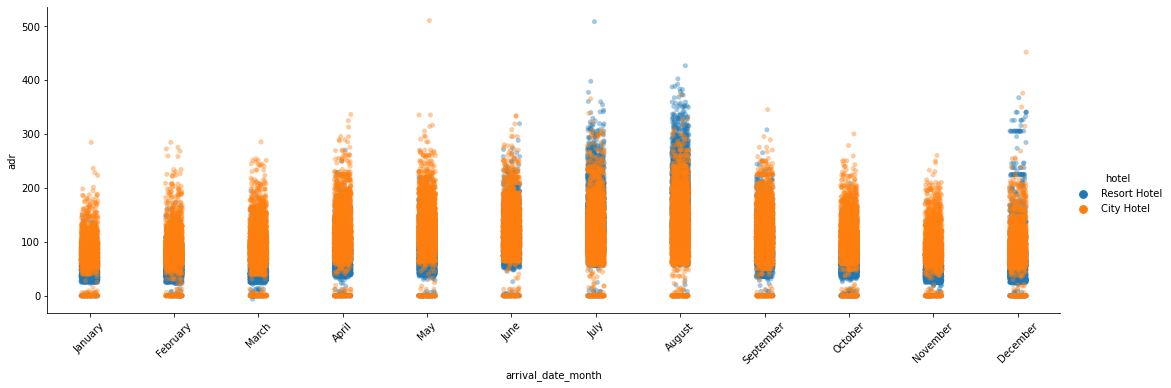

In [21]:
sns.catplot(data=not_canceled, x='arrival_date_month', y='adr', hue='hotel', alpha=.4, height=5, aspect=3)
plt.xticks(rotation=45)
plt.show()

__Insights from the Categorical plot showing cost (Avererage Daily Rate) for hotel stays__

- Bookings to City hotels remains consistent except during the summer months when we see a spike in price and lowering of price during the winter months.
- The summer months, especially during July and August sees a significant increase price in Resort Hotels. This can also signify that a popular time for guests to take their children on vacation are during the summer months of July and August and winder during December.
- Resort Hotels demand goes up with price during the summer months and the holidays in December.
- Throughout the year except for July, August and December. On Average, the Average Daily Rate of city hotels costs more.
- January, February and November has the lower cost for bookings.
- There is more information on City Hotel rates than Resort Hotels. This can also signify that more bookings at City Hotels then Resort

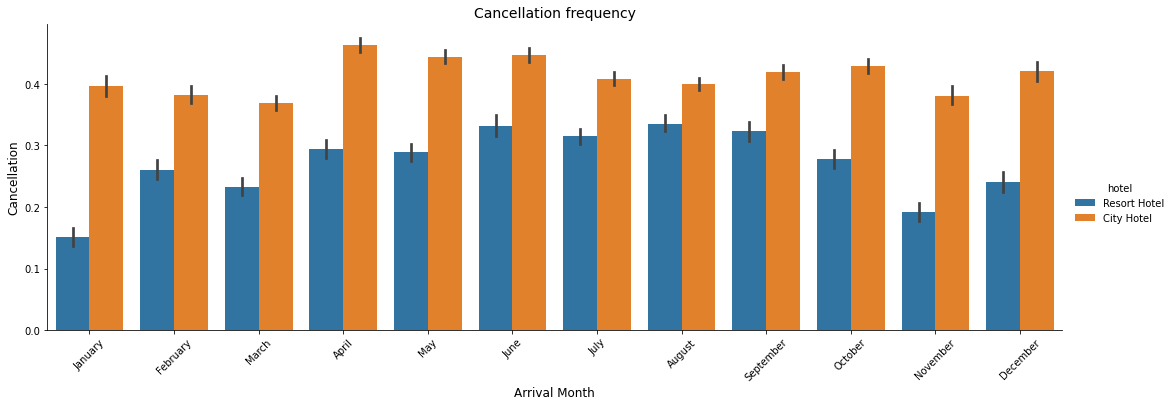

In [22]:
sns.catplot(kind='bar',data=hotel_df, x='arrival_date_month', y='is_canceled', hue='hotel', height=5, aspect=3)
plt.xticks(rotation=45)
plt.title('Cancellation frequency', fontsize=14)
plt.xlabel('Arrival Month',  fontsize=12)
plt.ylabel('Cancellation',  fontsize=12)
plt.show()

__Insights from the Categorical plot cancellation frequency__

- City Hotels receives more cancellations then resort hotels throughout the year. This can be due to several factors which included business travel and more flexibility with corporate accounts.
- Resort hotels receive less cancellations. Some factors may be due to a stricter cancellation policy in which additional fees are involved.
- Popular months of travel also receive more cancellations.
- Popular months also sees more cancellations in City Hotels than resort hotels.


#### Lenght of Stay

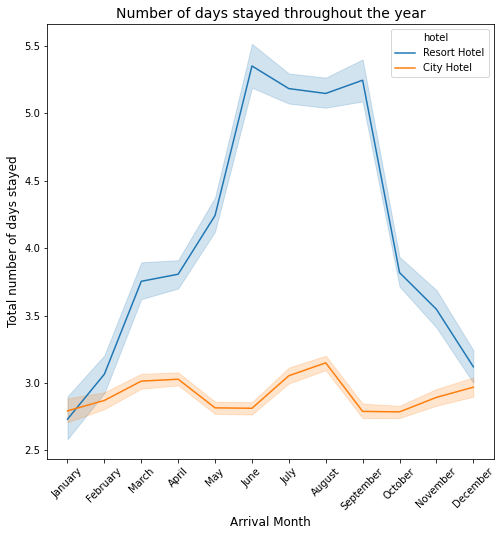

In [69]:
plt.figure(figsize=(8,8))
not_canceled['total_stay'] = not_canceled['stays_in_weekend_nights'] + not_canceled['stays_in_week_nights']
sns.lineplot(data=not_canceled, x = "arrival_date_month", y = "total_stay", hue="hotel")
plt.xticks(rotation=45)
plt.title('Number of days stayed throughout the year', fontsize=14)
plt.xlabel('Arrival Month', fontsize=12)
plt.ylabel('Total number of days stayed', fontsize=12)
plt.show()

__Insights from the Categorical plot cancellation frequency__

- Guests stays longer at Resort Hotels throughout the year. This may because of the perception that Resort Hotels may cost more and they do not visit that often or that Resort Hotels are viewed as a vacation desitination.
- Though there are more bookings in the previous slides for City Hotels, the lenght of stay is shorter. Some reasons could be for business purposes and access is easier in City Hotels sorrounded by more establishments.
- Over 5 Days at resort Hotels signifies vacation.

#### Total Number of Guests

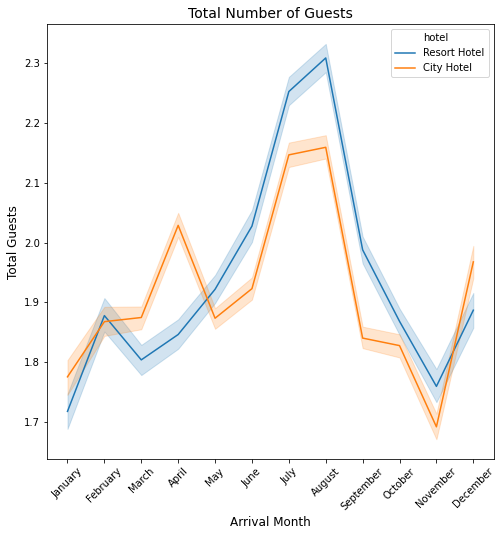

In [24]:
not_canceled['total_guests'] = not_canceled['adults'] + not_canceled['children'] + not_canceled['babies']

plt.figure(figsize=(8,8))
sns.lineplot(data=not_canceled, x = "arrival_date_month", y = "total_guests", hue="hotel")
plt.xticks(rotation=45)
plt.title('Total Number of Guests', fontsize=14)
plt.xlabel('Arrival Month', fontsize=12)
plt.ylabel('Total Guests', fontsize=12)
plt.show()

__Insights from the Line plot number of guests__

- The summer months see an increase number of guests in either City or Resort Hotels.
- Summer months sees more guests at Resort Hotels, this will continue throughout November. One factor may relate to families who tend to vacation more during these months and a Resort Hotel tends to be their vacation destination choice.
- January to April sees more guests in City Hotels, this can be attributed business travel during the first quarter of the year.
- Though there are more guests at resort hotels during the summer months, the increase in guests for both types of hotels has a consistent increase.
- Increase and decrease of hotel guests is seasonal, taking into account the best times for travel and vacation.

#### Means by which guests booked their stay

In [25]:
hotel_df['distribution_channel'].unique()

array(['Direct', 'Corporate', 'TA/TO', 'Undefined', 'GDS'], dtype=object)

In [26]:
distribution = hotel_df['distribution_channel'].value_counts().head(5)
distribution = pd.DataFrame(distribution)

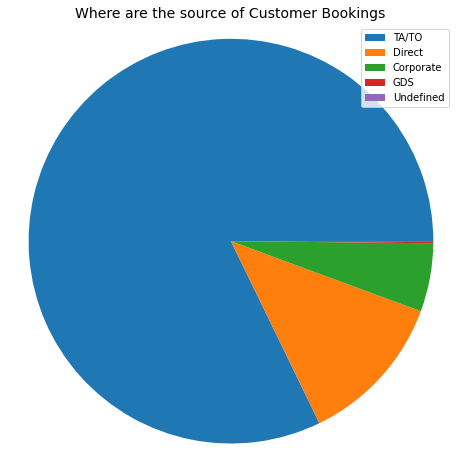

In [27]:
plt.figure(figsize=(8,8))
plt.pie(distribution)
plt.title('Where are the source of Customer Bookings', fontsize=14)
plt.legend(labels=distribution.index)
plt.axis('equal')
plt.show()

__Insights from the Pie plot indicating source of booking__

- Majority of bookings were through Travel Agents or Travel Operators. These include online booking companies such as Expedia. Online companies provide travel and tour services.
- The other two signigicant sources of booking are direct bookings throuh the hotel or through corporate for business travel.

#### Relationship of being in the waiting list and cancelations

In [28]:
hotel_df['waiting'] = hotel_df['days_in_waiting_list'].value_counts()

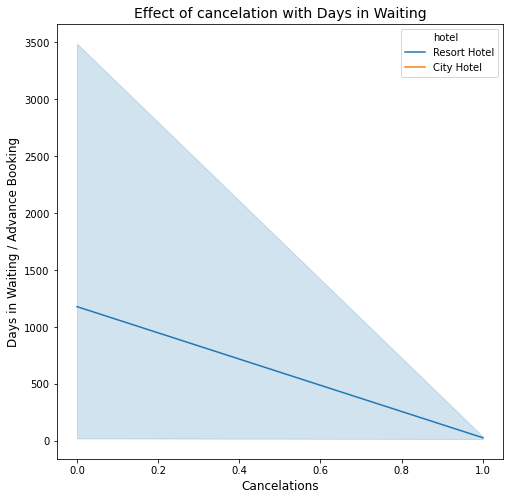

In [29]:
plt.figure(figsize=(8,8))
sns.lineplot(data=hotel_df, x = "is_canceled", y = "waiting", hue='hotel')
plt.title('Effect of cancelation with Days in Waiting', fontsize=14)
plt.xlabel('Cancelations', fontsize=12)
plt.ylabel('Days in Waiting / Advance Booking', fontsize=12)
plt.show()

__Insights from the Line plot indicating the effect cancelation have to waiting time__

- Indications that the longer the reservation was done in advance, the more likely a guest is to cancel. There could be several factors as anything can happen during the wait time. Some factors coulr be because of personal reasons or better or more affordable locations.
- The shorter the waiting waiting period, the less likely they are to cancel. This can also be attributed to business travel or emergency travel who needs these services. 

In [30]:
hotel_df['country'].value_counts().values

array([48586, 12129, 10415,  8568,  7287,  3766,  3375,  2342,  2224,
        2104,  2097,  1730,  1279,  1263,  1024,   999,   919,   669,
         632,   607,   500,   447,   435,   426,   362,   287,   259,
         248,   230,   214,   197,   171,   152,   133,   128,   103,
         101,   100,    85,    83,    83,    81,    80,    75,    74,
          71,    68,    67,    65,    65,    59,    57,    57,    55,
          51,    51,    51,    48,    40,    39,    39,    35,    34,
          32,    32,    31,    29,    29,    28,    27,    26,    26,
          24,    22,    21,    19,    19,    18,    18,    18,    17,
          16,    16,    15,    14,    14,    14,    13,    12,    12,
          12,    12,    11,    10,    10,    10,     9,     9,     9,
           8,     8,     8,     8,     8,     7,     7,     7,     6,
           6,     6,     5,     5,     5,     5,     5,     5,     4,
           4,     4,     4,     4,     4,     4,     4,     3,     3,
           3,     3,

### Model Preparation

Before creating the models we will first look for any class imbalances and further tune any features and parameters needed in order to establish an optimum selection or model performance.

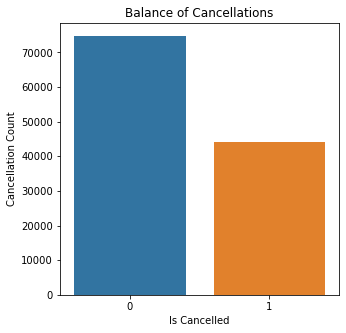

In [31]:
plt.figure(figsize=(5,5))
sns.countplot(hotel_df['is_canceled'])
plt.title('Balance of Cancellations')
plt.xlabel('Is Cancelled')
plt.ylabel('Cancellation Count')
plt.show()

__Ingsight from the cancellation variable__
- The cancellations shows a class imbalance with actually 'cancellations' to be less than bookings that have NOT been 'cancelled'

#### Parameter Tuning

We initially create a second datafram by encoding a few selected features which a few variables.

In [32]:
hotel_df2 = pd.get_dummies(data=hotel_df, columns=['hotel','customer_type', 'reserved_room_type', 'assigned_room_type'], drop_first=True)

Instead of One hot encoding the features below, we would run a label encoder since they contain several unique values. By using the label encoder, we will also be able to reduce dimensions which can cause overvitting.

The following categorical feature below has multiple categories. Instead of one hot encoding this, we will label encode the follwing features. I have decided to label encode these features as to avoid a model with too much dimentions. This should allow the model to perform better as well/

In [33]:
#Label Encoder
le = preprocessing.LabelEncoder()
hotel_df2['country'] = le.fit_transform(hotel_df2['country'])
hotel_df2['arrival_date_month'] = le.fit_transform(hotel_df2['arrival_date_month'])
hotel_df2['market_segment'] = le.fit_transform(hotel_df2['market_segment'])
hotel_df2['distribution_channel'] = le.fit_transform(hotel_df2['distribution_channel'])
hotel_df2['meal'] = le.fit_transform(hotel_df2['meal'])
hotel_df2['is_repeated_guest'] = le.fit_transform(hotel_df2['is_repeated_guest'])
hotel_df2['deposit_type'] = le.fit_transform(hotel_df2['deposit_type'])


In [34]:
hotel_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118898 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   hotel                           118898 non-null  object  
 1   is_canceled                     118898 non-null  int64   
 2   lead_time                       118898 non-null  int64   
 3   arrival_date_year               118898 non-null  int64   
 4   arrival_date_month              118898 non-null  category
 5   arrival_date_week_number        118898 non-null  int64   
 6   arrival_date_day_of_month       118898 non-null  int64   
 7   stays_in_weekend_nights         118898 non-null  int64   
 8   stays_in_week_nights            118898 non-null  int64   
 9   adults                          118898 non-null  int64   
 10  children                        118898 non-null  float64 
 11  babies                          118898 non-null  int64   
 12  me

In [35]:
hotel_df2.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'reservation_status',
       'reservation_status_date', 'waiting', 'hotel_Resort Hotel',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'reserved_room_type_B',
       'reserved_room_type_C', 'reserved_room_type_D', 'reserved_room_type_E',
       'reserved_room_type_F', 'reserved_room_type_G', 'reserved_room_type_H',
       'reserved_room_type_L', 'reserved_room_type_P', 'assigned_room_type_B',
       'a

We have also identifies a few object data types. As not not interfere witht he model we have taken them of. The 'waiting'feature was a unncessary feature created earlier to display the data, this woll not be needed. Additionally, since the reservation status date and reservation status are related, both of these feautures will be droped before creating the model

In [36]:
#Identify target and dependent features
y = hotel_df2['is_canceled']
X = hotel_df2.drop(['is_canceled','reservation_status_date', 'waiting', 'reservation_status'], axis=1)

In [37]:
#### Splitting the Data into Test and Training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

### Model Creation

In our attempt to predict and classify potential bookings which may or may not get cancelled, we will be using the following models. The following models were created in order to run a classification task. The classification task the models will be performing is by predicting if a hotel booking will be canceled or not. 
- Logistic Regression
- Random Forest Ensemble
- Balanced Random Forest Ensemble (to address the data imbalance)
- Boosting
- XGBoost

##### Logistic Regression

In [38]:
lr = LogisticRegressionCV(cv=5, random_state=42, penalty='l2', n_jobs = -1)
lr.fit(X_train,y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [39]:
confusion_matrix(y_train, y_pred_train)

array([[53853,  5943],
       [14503, 20819]], dtype=int64)

In [40]:
#Printing out the classification report
lr_report = classification_report(y_test, y_pred_test)
print(lr_report)

              precision    recall  f1-score   support

           0       0.78      0.90      0.84     14949
           1       0.77      0.58      0.66      8831

    accuracy                           0.78     23780
   macro avg       0.78      0.74      0.75     23780
weighted avg       0.78      0.78      0.77     23780



##### Random Forest Ensemble

In [41]:
clf = ensemble.RandomForestClassifier(max_depth=3, n_estimators=5, n_jobs = -1)
clf = clf.fit(X_train, y_train)

y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

In [42]:
cross_val_score(clf, X_test, y_test, cv=5)

array([0.74726661, 0.74474348, 0.75336417, 0.76408747, 0.7510513 ])

In [43]:
#Printing out the classification report
rfe_report = classification_report(y_test, y_pred_test)
print(rfe_report)

              precision    recall  f1-score   support

           0       0.73      0.99      0.84     14949
           1       0.96      0.37      0.53      8831

    accuracy                           0.76     23780
   macro avg       0.84      0.68      0.68     23780
weighted avg       0.81      0.76      0.72     23780



In [44]:
confusion_matrix(y_test, y_pred_test)

array([[14797,   152],
       [ 5593,  3238]], dtype=int64)

In [45]:
feature = {X: y for X,y in zip(X_test.columns, clf.feature_importances_)}

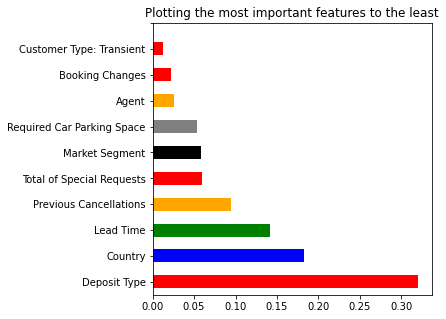

In [46]:
plt.figure(figsize=(5,5))
pd.Series(clf.feature_importances_, index=X_test.columns).nlargest(10).plot(kind='barh', color =['red', 'blue', 'green', 'orange', 'red', 'black', 'grey', 'orange', 'red'])
plt.title('Plotting the most important features to the least')
plt.yticks([0,1,2,3,4,5,6,7,8,9,10],['Deposit Type','Country', 'Lead Time', 'Previous Cancellations', 'Total of Special Requests', 'Market Segment', 
                                    'Required Car Parking Space', 'Agent', 'Booking Changes', 'Customer Type: Transient'])
plt.show()

##### Balanced Random Forest Ensemble

In [47]:
brf = BalancedRandomForestClassifier(max_depth=4, n_estimators=5, n_jobs = -1)
brf.fit(X_train, y_train)

y_pred_train = brf.predict(X_train)
y_pred_test = brf.predict(X_test)

In [48]:
#Printing out the classification report
brf_report = classification_report(y_test, y_pred_test)
print(brf_report)

              precision    recall  f1-score   support

           0       0.78      0.93      0.85     14949
           1       0.83      0.57      0.67      8831

    accuracy                           0.79     23780
   macro avg       0.80      0.75      0.76     23780
weighted avg       0.80      0.79      0.78     23780



In [49]:
confusion_matrix(y_test, y_pred_test)

array([[13893,  1056],
       [ 3841,  4990]], dtype=int64)

In [50]:
feature = {X: y for X,y in zip(X_test.columns, brf.feature_importances_)}

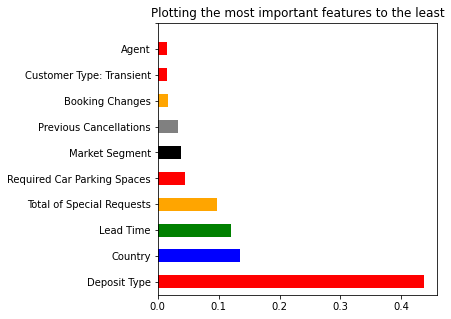

In [51]:
plt.figure(figsize=(5,5))
pd.Series(brf.feature_importances_, index=X_test.columns).nlargest(10).plot(kind='barh', color =['red', 'blue', 'green', 'orange', 'red', 'black', 'grey', 'orange', 'red'])
plt.title('Plotting the most important features to the least')
plt.yticks([0,1,2,3,4,5,6,7,8,9,10],['Deposit Type','Country', 'Lead Time', 'Total of Special Requests', 'Required Car Parking Spaces', 'Market Segment', 
                                    'Previous Cancellations', 'Booking Changes', 'Customer Type: Transient', 'Agent'])
plt.show()

##### Boosting

In [52]:
params = {'n_estimators': 200,
          'max_depth': 3,
          'loss': 'deviance'}

boost = ensemble.GradientBoostingClassifier(**params)
boost.fit(X_train, y_train)

predict_train = boost.predict(X_train)
predict_test = boost.predict(X_test)

In [53]:
#Cross Validation
cross_val_score(boost, X_test, y_test, cv=5)

array([0.85071489, 0.8559714 , 0.86038688, 0.8538688 , 0.86059714])

In [54]:
#Printing out the classification report
boost_report = classification_report(y_test, y_pred_test)
print(boost_report)

              precision    recall  f1-score   support

           0       0.78      0.93      0.85     14949
           1       0.83      0.57      0.67      8831

    accuracy                           0.79     23780
   macro avg       0.80      0.75      0.76     23780
weighted avg       0.80      0.79      0.78     23780



In [55]:
confusion_matrix(y_test, y_pred_test)

array([[13893,  1056],
       [ 3841,  4990]], dtype=int64)

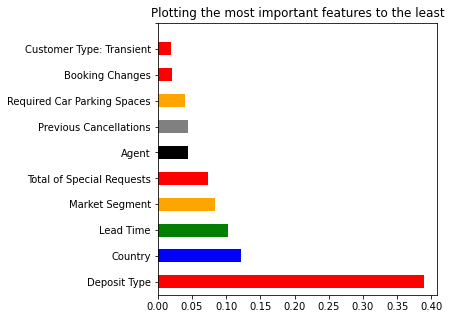

In [56]:
#Plotting Feature Importances
plt.figure(figsize=(5,5))
pd.Series(boost.feature_importances_, index=X_test.columns).nlargest(10).plot(kind='barh', color =['red', 'blue', 'green', 'orange', 'red', 'black', 'grey', 'orange', 'red'])
plt.title('Plotting the most important features to the least')
plt.yticks([0,1,2,3,4,5,6,7,8,9,10],['Deposit Type','Country', 'Lead Time', 'Market Segment', 'Total of Special Requests', 'Agent', 
                                    'Previous Cancellations', 'Required Car Parking Spaces', 'Booking Changes', 'Customer Type: Transient'])
plt.show()

##### XGBoost

In [57]:
xgboost = XGBClassifier(**params)

xgboost.fit(X_train, y_train)


XGBClassifier(loss='deviance', n_estimators=200)

In [58]:
predict_train = xgboost.predict(X_train)
predict_test = xgboost.predict(X_test)

In [59]:
#Cross Validation
cross_val_score(xgboost, X_test, y_test, cv=5)

array([0.85155593, 0.8538688 , 0.85828427, 0.85155593, 0.85870479])

In [60]:
confusion_matrix(y_test, y_pred_test)

array([[13893,  1056],
       [ 3841,  4990]], dtype=int64)

In [61]:
#Printing out the classification report
xgboost_report = classification_report(y_test, y_pred_test)
print(xgboost_report)

              precision    recall  f1-score   support

           0       0.78      0.93      0.85     14949
           1       0.83      0.57      0.67      8831

    accuracy                           0.79     23780
   macro avg       0.80      0.75      0.76     23780
weighted avg       0.80      0.79      0.78     23780



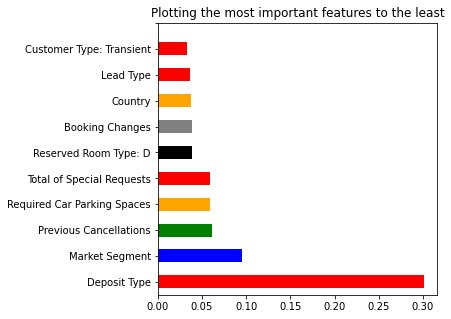

In [62]:
#Getting Feature importance and plotting
plt.figure(figsize=(5,5))
pd.Series(xgboost.feature_importances_, index=X_test.columns).nlargest(10).plot(kind='barh', color =['red', 'blue', 'green', 'orange', 'red', 'black', 'grey', 'orange', 'red'])
plt.title('Plotting the most important features to the least')
plt.yticks([0,1,2,3,4,5,6,7,8,9,10],['Deposit Type','Market Segment', 'Previous Cancellations', 'Required Car Parking Spaces', 'Total of Special Requests', 'Reserved Room Type: D', 
                                    'Booking Changes', 'Country', 'Lead Type', 'Customer Type: Transient'])
plt.show()

##### Classification Reports

In [63]:
print('The logistic regression classification Report:\n', lr_report)
print('The random forest ensemble classification Report:\n', rfe_report)
print('The balance random forest classification Report:\n', brf_report)
print('The Boosting classification Report:\n', boost_report)
print('The XGBoosting classification Report:\n', xgboost_report)

The logistic regression classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.84     14949
           1       0.77      0.58      0.66      8831

    accuracy                           0.78     23780
   macro avg       0.78      0.74      0.75     23780
weighted avg       0.78      0.78      0.77     23780

The random forest ensemble classification Report:
               precision    recall  f1-score   support

           0       0.73      0.99      0.84     14949
           1       0.96      0.37      0.53      8831

    accuracy                           0.76     23780
   macro avg       0.84      0.68      0.68     23780
weighted avg       0.81      0.76      0.72     23780

The balance random forest classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85     14949
           1       0.83      0.57      0.67      8831

    accuracy                     

##### Finding the best Parameters with Gridsearch

In [64]:
#Balanced Random Forest Ensemble 
#brf_param = {'criterion':('gini', 'entropy'), 
#              'max_depth': [2,3,4],
#              'class_weight':('balanced_subsample','balanced'),
#             'n_jobs': [-1]}

# brf = BalancedRandomForestClassifier()

# grd = GridSearchCV(brf, brf_param)
# grd.fit(X_train, y_train)

# grd.best_params_


In [65]:
#XGBoost
# xgboost_param = {'loss':('deviance', 'exponential'), 
#                  'n_estimators':[100, 200, 300],
#                  'max_depth': [2,3,4],
#                  'n_jobs': [-1]}

# xgb = XGBClassifier()

# grd = GridSearchCV(xgb, xgboost_param)
# grd.fit(X_train, y_train)

# grd.best_params_


### Summary

Amongst the several models created, we can summarize which performed poorly and which was the best performer.

With a precision score of both 79% in classifing both 'canceled' and 'not canceled'. A recall of 91% for not cancelled and 60% for not canceled. The __Logistic Regression__ model performed the poorest.

In contrast, the __balanced random classification model__ performed equally as good at the __XGBoost__ model. These models avoided overfitting and was the best performers among the other models. 


### Future Considerations

- Find other tools which can resolve the class imbalance. 
- Though majority are Europe. We can focus more specifically on bookings per country.
- The dataset focuses on several years. There years could be first separated then looked at it via yearly perspective. A Time series analysis can help with this.
- A grid search parameter, finding the best parameters for each model will also be ideal.
- There are also several improvements that can be done such as selecting the right features and discarding irrelevand features.

In [66]:
not_canceled['total_guests'] = not_canceled['adults'] + not_canceled['children'] + not_canceled['babies']

not_canceled['total_guests'].iplot()

# plt.figure(figsize=(8,8))
# sns.lineplot(data=not_canceled, x = "arrival_date_month", y = "total_guests", hue="hotel")
# plt.xticks(rotation=45)
# plt.title('Total Number of Guests', fontsize=14)
# plt.xlabel('Arrival Month', fontsize=12)
# plt.ylabel('Total Guests', fontsize=12)
# plt.show()